<h1 style="text-align: center;">Iteration One – Formula 1</h1>

<h3 style="text-align: center;">Kaloyan Rakov</h3>

Formula 1 is a motorsport race, including 10 teams with 2 drivers each. The championship is divided into 2 titles: the Drivers' Championship (individual for each driver) and the Constructor’s Championship (Team-based). In this notebook I will dive into all the factors that have an effect on the drivers' performances and create a machine-learning model that will predict them. In later iterations I can go into team strategies & environmental effects.

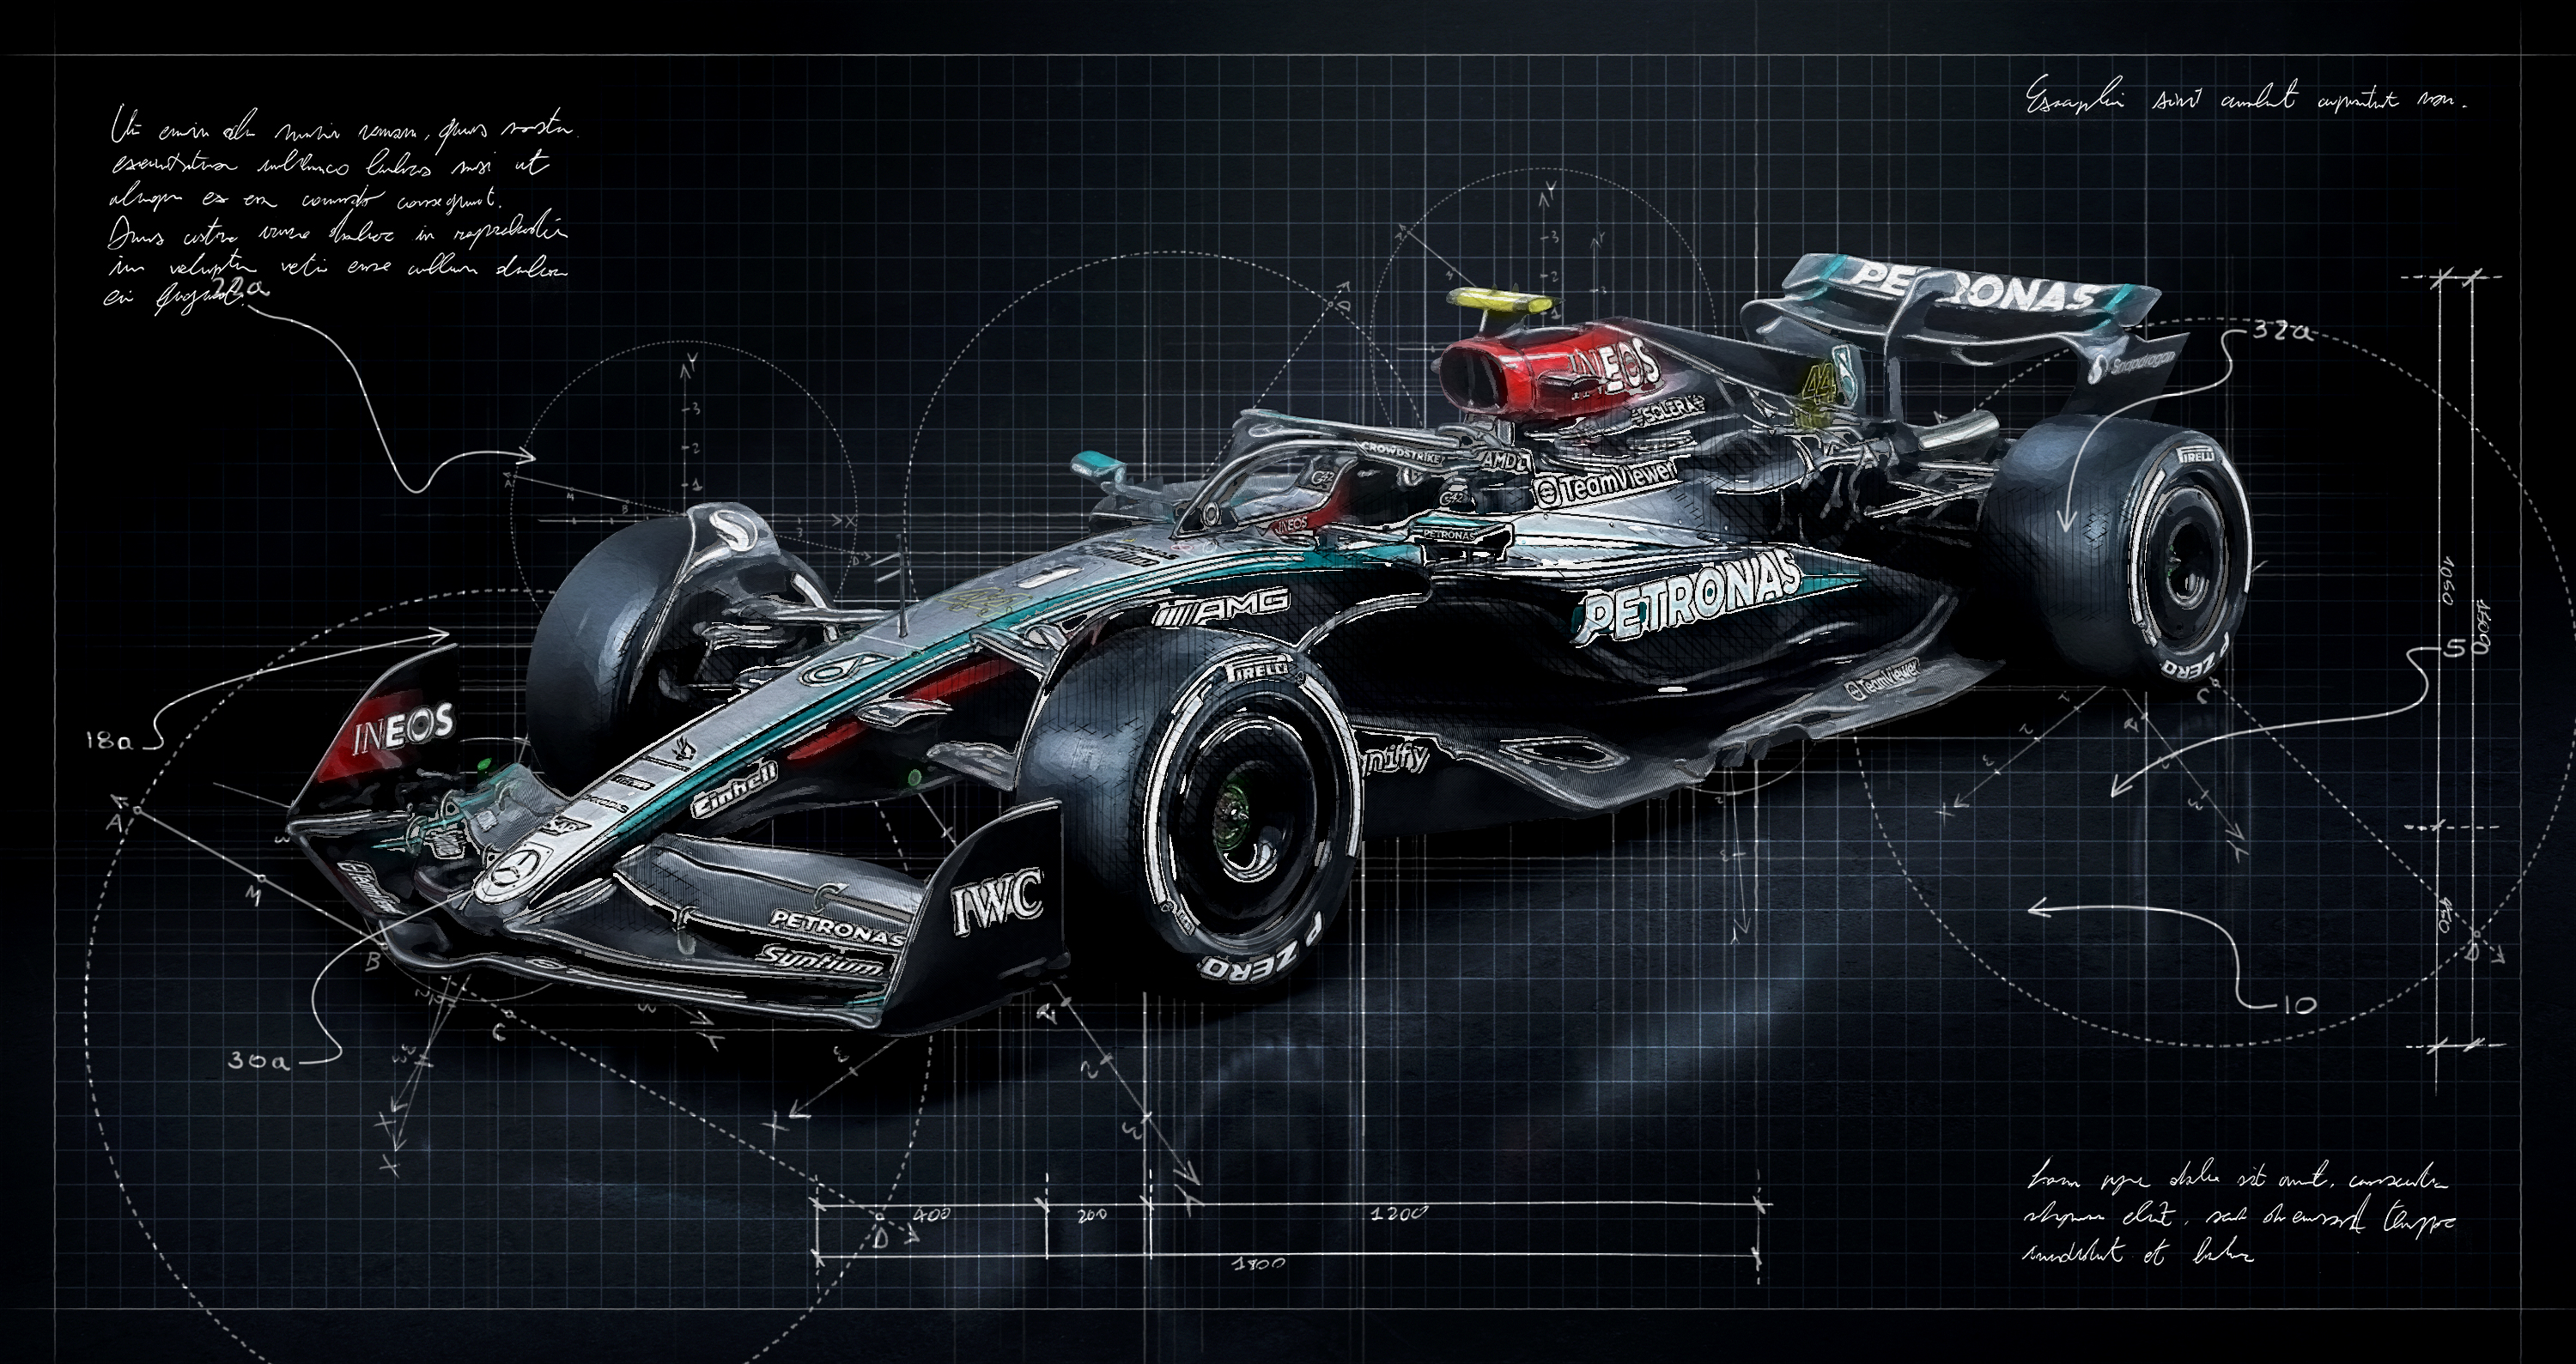

In [146]:
from IPython.display import Image
Image(filename='Mercedes.jpg')

# Data provisioning
What data are we working with:

For this project I am working with multiple datasets. One of them is the data from last season, as it gives us important context about the drivers and their past performances. The "Formula1_2024season_raceResults.csv" gives us access to every result every driver has produced throughout all of the races on the 2024 calendar. The other datasets are collected for each individual race and are based on the drivers' qualifying results for said race. It's important to look at each race individually, since performances vary considerably from track to track and otherwise we would be oversimplifying the project.

Loading the data:

In [147]:
import pandas as pd
df = pd.read_csv('Formula1_2024season_raceResults.csv')

# Sampling the data:
Let's get a better idea of what the the dataset is by printing the first 5 lines...

In [148]:
df.head(5)

Track Position  No           Driver                        Team  \
0  Bahrain        1   1   Max Verstappen  Red Bull Racing Honda RBPT   
1  Bahrain        2  11     Sergio Perez  Red Bull Racing Honda RBPT   
2  Bahrain        3  55     Carlos Sainz                     Ferrari   
3  Bahrain        4  16  Charles Leclerc                     Ferrari   
4  Bahrain        5  63   George Russell                    Mercedes   

   Starting Grid  Laps Time/Retired  Points Set Fastest Lap Fastest Lap Time  
0              1    57  1:31:44.742      26             Yes         1:32.608  
1              5    57      +22.457      18              No         1:34.364  
2              4    57      +25.110      15              No         1:34.507  
3              2    57      +39.669      12              No         1:34.090  
4              3    57      +46.788      10              No         1:35.065

... and the last 5 lines

In [149]:
df.tail(5)

Track Position  No            Driver                        Team  \
474  Abu Dhabi       16  20   Kevin Magnussen                Haas Ferrari   
475  Abu Dhabi       17  30       Liam Lawson               RB Honda RBPT   
476  Abu Dhabi       NC  77   Valtteri Bottas         Kick Sauber Ferrari   
477  Abu Dhabi       NC  43  Franco Colapinto           Williams Mercedes   
478  Abu Dhabi       NC  11      Sergio Perez  Red Bull Racing Honda RBPT   

     Starting Grid  Laps Time/Retired  Points Set Fastest Lap Fastest Lap Time  
474             14    57       +1 lap       0             Yes         1:25.637  
475             12    55          DNF       0              No         1:28.751  
476              9    30          DNF       0              No         1:29.482  
477             20    26          DNF       0              No         1:29.411  
478             10     0          DNF       0              No              NaN

The race ends when the first racer completes the needed number of laps, and then everyone following him finishes theirs. That’s why all the racers after the first one are recorded as "+SS.sss", and the winner is recorded as “H:MM:SS.sss”. In order for me to use the data, I will need to process all the times to be following the same format.
Some racers however, get lapped by the winner (the winner manages to complete a full lap around them), which means that when the race finishes, a number of the racers haven’t completed the full number of laps. They are being recorded as “+1 Lap”, “+2 Laps”.
There are also the drivers listed as NC (Not Classified) as their final positions – this happens when a driver starts the race, but doesn’t complete at least 90% of it (often caused by accidents or machine failures which in the results is being listed as DNF (Did Not Finish), DSQ (Disqualified) or rarely even  DNS (Did Not Start)). 

# Preprocessing

Let's make sure that all the racers that have completed the required amount of laps have their times recorded in the same format: “H:MM:SS.sss” (Here, we are going to call that "Absolute Time"). In the case of a driver having to complete more laps after the race is finished, we are gonna record them as PF (Premature Finish) + the number of laps they haven't completed. If a racer doesn't finish they will be classified as DNF (Regardless of the reason - DNF, DSQ, DNS).

In [150]:
absolute_times = []

for _, row in df.iterrows():
    time_str = str(row["Time/Retired"]).strip()
    
    if time_str.startswith("+"):
        if time_str[1:].split()[0].isdigit():
            absolute_times.append(f"PF {time_str.split()[0]} lap")
            continue

        winner_mask = (df["Track"] == row["Track"]) & (df["Position"].astype(str).str.strip() == "1")
        
        if winner_mask.any():
            winner_time_str = str(df.loc[winner_mask, "Time/Retired"].values[0])
            
            if ":" in winner_time_str:
                winner_parts = list(map(float, winner_time_str.split(":")))
                winner_total = winner_parts[0]*3600 + winner_parts[1]*60 + winner_parts[2] if len(winner_parts) == 3 else winner_parts[0]*60 + winner_parts[1]
                
                try:
                    delta = float(time_str[1:])
                    absolute_total = winner_total + delta
                    hours = int(absolute_total // 3600)
                    minutes = int((absolute_total % 3600) // 60)
                    seconds = absolute_total % 60
                    absolute_time = f"{hours}:{minutes:02d}:{seconds:06.3f}"
                    absolute_times.append(absolute_time)
                except:
                    absolute_times.append("Time calculation error")
            else:
                absolute_times.append("Invalid winner time")
        else:
            absolute_times.append("No winner found")
    else:
        absolute_times.append(time_str)

df["Absolute Time"] = absolute_times

Let's take a look at how the data looks now. There is a new column with the Absoulte Time where they follow the same format.

In [151]:
df.head(10)

Track Position  No           Driver                          Team  \
0  Bahrain        1   1   Max Verstappen    Red Bull Racing Honda RBPT   
1  Bahrain        2  11     Sergio Perez    Red Bull Racing Honda RBPT   
2  Bahrain        3  55     Carlos Sainz                       Ferrari   
3  Bahrain        4  16  Charles Leclerc                       Ferrari   
4  Bahrain        5  63   George Russell                      Mercedes   
5  Bahrain        6   4     Lando Norris              McLaren Mercedes   
6  Bahrain        7  44   Lewis Hamilton                      Mercedes   
7  Bahrain        8  81    Oscar Piastri              McLaren Mercedes   
8  Bahrain        9  14  Fernando Alonso  Aston Martin Aramco Mercedes   
9  Bahrain       10  18     Lance Stroll  Aston Martin Aramco Mercedes   

   Starting Grid  Laps Time/Retired  Points Set Fastest Lap Fastest Lap Time  \
0              1    57  1:31:44.742      26             Yes         1:32.608   
1              5    57      +22.457      18              No         1:34.364   
2              4    57      +25.110      15              No         1:34.507   
3              2    57      +39.669      12              No         1:34.090   
4              3    57      +46.788      10              No         1:35.065   
5              7    57      +48.458       8              No         1:34.476   
6              9    57      +50.324       6              No         1:34.722   
7              8    57      +56.082       4              No         1:34.983   
8              6    57      +74.887       2              No         1:34.199   
9             12    57      +93.216       1              No         1:35.632   

  Absolute Time  
0   1:31:44.742  
1   1:32:07.199  
2   1:32:09.852  
3   1:32:24.411  
4   1:32:31.530  
5   1:32:33.200  
6   1:32:35.066  
7   1:32:40.824  
8   1:32:59.629  
9   1:33:17.958

In [152]:
df.tail(10)

Track Position  No            Driver                          Team  \
469  Abu Dhabi       11  23   Alexander Albon             Williams Mercedes   
470  Abu Dhabi       12  22      Yuki Tsunoda                 RB Honda RBPT   
471  Abu Dhabi       13  24       Guanyu Zhou           Kick Sauber Ferrari   
472  Abu Dhabi       14  18      Lance Stroll  Aston Martin Aramco Mercedes   
473  Abu Dhabi       15  61       Jack Doohan                Alpine Renault   
474  Abu Dhabi       16  20   Kevin Magnussen                  Haas Ferrari   
475  Abu Dhabi       17  30       Liam Lawson                 RB Honda RBPT   
476  Abu Dhabi       NC  77   Valtteri Bottas           Kick Sauber Ferrari   
477  Abu Dhabi       NC  43  Franco Colapinto             Williams Mercedes   
478  Abu Dhabi       NC  11      Sergio Perez    Red Bull Racing Honda RBPT   

     Starting Grid  Laps Time/Retired  Points Set Fastest Lap  \
469             18    57       +1 lap       0              No   
470             11    57       +1 lap       0              No   
471             15    57       +1 lap       0              No   
472             13    57       +1 lap       0              No   
473             17    57       +1 lap       0              No   
474             14    57       +1 lap       0             Yes   
475             12    55          DNF       0              No   
476              9    30          DNF       0              No   
477             20    26          DNF       0              No   
478             10     0          DNF       0              No   

    Fastest Lap Time Absolute Time  
469         1:29.438     PF +1 lap  
470         1:29.200     PF +1 lap  
471         1:27.982     PF +1 lap  
472         1:28.604     PF +1 lap  
473         1:29.121     PF +1 lap  
474         1:25.637     PF +1 lap  
475         1:28.751           DNF  
476         1:29.482           DNF  
477         1:29.411           DNF  
478              NaN           DNF

When the time isn't available, under "Absolute Time" we either have DNF or The Laps they needed to complete.

Formula 1 is a pretty expensive sport, which relies heavily on sponsorships, which change quite often and subsequently so do the teams' names. There are two types of teams: Works Teams (aka Factory Teams) and Customer Teams. The Factory Teams produce their own cars and engines (Ferrari, Mercedes, etc.), while the Customer teams have to buy their engines (or other parts) from the Works teams. If a team like Haas uses a engine supplied to them by Ferrari, then they will need to carry the Ferrari name as their sponsor. That's how we end up with teams like Aston Martin Aramco Mercedes and Kick Sauber Ferrari. In order to avoid confusion I will adress the teams by their shortened, most simple names. Some teams have renamed themselves for other sponsoring reasons, so I will use their 2025 names.

In [153]:
team_name_mapping = {
    'McLaren Mercedes': 'McLaren',
    'Mercedes': 'Mercedes',
    'Red Bull Racing Honda RBPT': 'Red Bull Racing',
    'Ferrari': 'Ferrari',
    'RB Honda RBPT': 'Racing Bulls',
    'Williams Mercedes': 'Williams',
    'Haas Ferrari': 'Haas',
    'Kick Sauber Ferrari': 'Kick Sauber',
    'Aston Martin Aramco Mercedes': 'Aston Martin',
    'Alpine Renault': 'Alpine'
}
df['Team'] = df['Team'].replace(team_name_mapping)

Now we can see that our dataset is using the current team names:

In [154]:
print(df['Team'].unique())

['Red Bull Racing' 'Ferrari' 'Mercedes' 'McLaren' 'Aston Martin'
 'Kick Sauber' 'Haas' 'Racing Bulls' 'Williams' 'Alpine']


# Cleaning

We need to make sure that there are no empty rows or invalid data.
Here is what the data looks before cleaning:

In [155]:
df.head(15)

Track Position  No            Driver             Team  Starting Grid  \
0   Bahrain        1   1    Max Verstappen  Red Bull Racing              1   
1   Bahrain        2  11      Sergio Perez  Red Bull Racing              5   
2   Bahrain        3  55      Carlos Sainz          Ferrari              4   
3   Bahrain        4  16   Charles Leclerc          Ferrari              2   
4   Bahrain        5  63    George Russell         Mercedes              3   
5   Bahrain        6   4      Lando Norris          McLaren              7   
6   Bahrain        7  44    Lewis Hamilton         Mercedes              9   
7   Bahrain        8  81     Oscar Piastri          McLaren              8   
8   Bahrain        9  14   Fernando Alonso     Aston Martin              6   
9   Bahrain       10  18      Lance Stroll     Aston Martin             12   
10  Bahrain       11  24       Guanyu Zhou      Kick Sauber             17   
11  Bahrain       12  20   Kevin Magnussen             Haas             15   
12  Bahrain       13   3  Daniel Ricciardo     Racing Bulls             14   
13  Bahrain       14  22      Yuki Tsunoda     Racing Bulls             11   
14  Bahrain       15  23   Alexander Albon         Williams             13   

    Laps Time/Retired  Points Set Fastest Lap Fastest Lap Time Absolute Time  
0     57  1:31:44.742      26             Yes         1:32.608   1:31:44.742  
1     57      +22.457      18              No         1:34.364   1:32:07.199  
2     57      +25.110      15              No         1:34.507   1:32:09.852  
3     57      +39.669      12              No         1:34.090   1:32:24.411  
4     57      +46.788      10              No         1:35.065   1:32:31.530  
5     57      +48.458       8              No         1:34.476   1:32:33.200  
6     57      +50.324       6              No         1:34.722   1:32:35.066  
7     57      +56.082       4              No         1:34.983   1:32:40.824  
8     57      +74.887       2              No         1:34.199   1:32:59.629  
9     57      +93.216       1              No         1:35.632   1:33:17.958  
10    56       +1 lap       0              No         1:35.458     PF +1 lap  
11    56       +1 lap       0              No         1:35.570     PF +1 lap  
12    56       +1 lap       0              No         1:35.163     PF +1 lap  
13    56       +1 lap       0              No         1:35.833     PF +1 lap  
14    56       +1 lap       0              No         1:35.723     PF +1 lap

Let's check if there are any rows with empty data:

In [156]:
df.isnull().sum()

Track                0
Position             0
No                   0
Driver               0
Team                 0
Starting Grid        0
Laps                 0
Time/Retired         0
Points               0
Set Fastest Lap      0
Fastest Lap Time    16
Absolute Time        0
dtype: int64

We can see that the only column that has any empty data is "Fastest Lap Time". Let's take a closer look:

In [157]:
missing_fastest_lap = df[df["Fastest Lap Time"].isnull()]
display(missing_fastest_lap)

Track Position  No            Driver             Team  \
39    Saudi Arabia       NC  10      Pierre Gasly           Alpine   
77           Japan       NC   3  Daniel Ricciardo     Racing Bulls   
78           Japan       NC  23   Alexander Albon         Williams   
155         Monaco       NC  31      Esteban Ocon           Alpine   
156         Monaco       NC  11      Sergio Perez  Red Bull Racing   
157         Monaco       NC  27   Nico Hulkenberg             Haas   
158         Monaco       NC  20   Kevin Magnussen             Haas   
238  Great Britain       NC  10      Pierre Gasly           Alpine   
378  United States       NC  44    Lewis Hamilton         Mercedes   
397         Mexico       NC  23   Alexander Albon         Williams   
398         Mexico       NC  22      Yuki Tsunoda     Racing Bulls   
416         Brazil       NC  23   Alexander Albon         Williams   
417         Brazil       NC  18      Lance Stroll     Aston Martin   
457          Qatar       NC  43  Franco Colapinto         Williams   
458          Qatar       NC  31      Esteban Ocon           Alpine   
478      Abu Dhabi       NC  11      Sergio Perez  Red Bull Racing   

     Starting Grid  Laps Time/Retired  Points Set Fastest Lap  \
39              18     1          DNF       0              No   
77              11     0          DNF       0              No   
78              14     0          DNF       0              No   
155             11     0          DNF       0              No   
156             16     0          DNF       0              No   
157             19     0          DNF       0              No   
158             20     0          DNF       0              No   
238             19     0          DNS       0              No   
378             17     1          DNF       0              No   
397              9     0          DNF       0              No   
398             11     0          DNF       0              No   
416              7     0          DNS       0              No   
417             10     0          DNS       0              No   
457             19     0          DNF       0              No   
458             20     0          DNF       0              No   
478             10     0          DNF       0              No   

    Fastest Lap Time Absolute Time  
39               NaN           DNF  
77               NaN           DNF  
78               NaN           DNF  
155              NaN           DNF  
156              NaN           DNF  
157              NaN           DNF  
158              NaN           DNF  
238              NaN           DNS  
378              NaN           DNF  
397              NaN           DNF  
398              NaN           DNF  
416              NaN           DNS  
417              NaN           DNS  
457              NaN           DNF  
458              NaN           DNF  
478              NaN           DNF

We can see that the data here is all NC as their position and they all were retired as DNF or DNS. Those rows are all results of the drivers crashing, failing to start or a different type of emergency, which exaplins why they don't have a "Fastest Lap Time". We could either delete these rows or update the data from "NaN" to "No time". I think the latter is a better option since I wanna keep as much data as possible for the analysis later on.

In [158]:
df["Fastest Lap Time"] = df["Fastest Lap Time"].fillna("No time")
missing_fastest_lap = df[df["Fastest Lap Time"] == "No time"]
display(missing_fastest_lap)

Track Position  No            Driver             Team  \
39    Saudi Arabia       NC  10      Pierre Gasly           Alpine   
77           Japan       NC   3  Daniel Ricciardo     Racing Bulls   
78           Japan       NC  23   Alexander Albon         Williams   
155         Monaco       NC  31      Esteban Ocon           Alpine   
156         Monaco       NC  11      Sergio Perez  Red Bull Racing   
157         Monaco       NC  27   Nico Hulkenberg             Haas   
158         Monaco       NC  20   Kevin Magnussen             Haas   
238  Great Britain       NC  10      Pierre Gasly           Alpine   
378  United States       NC  44    Lewis Hamilton         Mercedes   
397         Mexico       NC  23   Alexander Albon         Williams   
398         Mexico       NC  22      Yuki Tsunoda     Racing Bulls   
416         Brazil       NC  23   Alexander Albon         Williams   
417         Brazil       NC  18      Lance Stroll     Aston Martin   
457          Qatar       NC  43  Franco Colapinto         Williams   
458          Qatar       NC  31      Esteban Ocon           Alpine   
478      Abu Dhabi       NC  11      Sergio Perez  Red Bull Racing   

     Starting Grid  Laps Time/Retired  Points Set Fastest Lap  \
39              18     1          DNF       0              No   
77              11     0          DNF       0              No   
78              14     0          DNF       0              No   
155             11     0          DNF       0              No   
156             16     0          DNF       0              No   
157             19     0          DNF       0              No   
158             20     0          DNF       0              No   
238             19     0          DNS       0              No   
378             17     1          DNF       0              No   
397              9     0          DNF       0              No   
398             11     0          DNF       0              No   
416              7     0          DNS       0              No   
417             10     0          DNS       0              No   
457             19     0          DNF       0              No   
458             20     0          DNF       0              No   
478             10     0          DNF       0              No   

    Fastest Lap Time Absolute Time  
39           No time           DNF  
77           No time           DNF  
78           No time           DNF  
155          No time           DNF  
156          No time           DNF  
157          No time           DNF  
158          No time           DNF  
238          No time           DNS  
378          No time           DNF  
397          No time           DNF  
398          No time           DNF  
416          No time           DNS  
417          No time           DNS  
457          No time           DNF  
458          No time           DNF  
478          No time           DNF

Now let's check if there are any null values left in our data:

In [159]:
df.isnull().sum()

Track               0
Position            0
No                  0
Driver              0
Team                0
Starting Grid       0
Laps                0
Time/Retired        0
Points              0
Set Fastest Lap     0
Fastest Lap Time    0
Absolute Time       0
dtype: int64

As we can see, there are no more null values in our dataset. It's clean, which means that now we can dive a little bit deeper into what the data actually represents. A good way of doing that is through visualisation.

# Visualisation

The first thing we might want to look into is the number of races each driver has won:

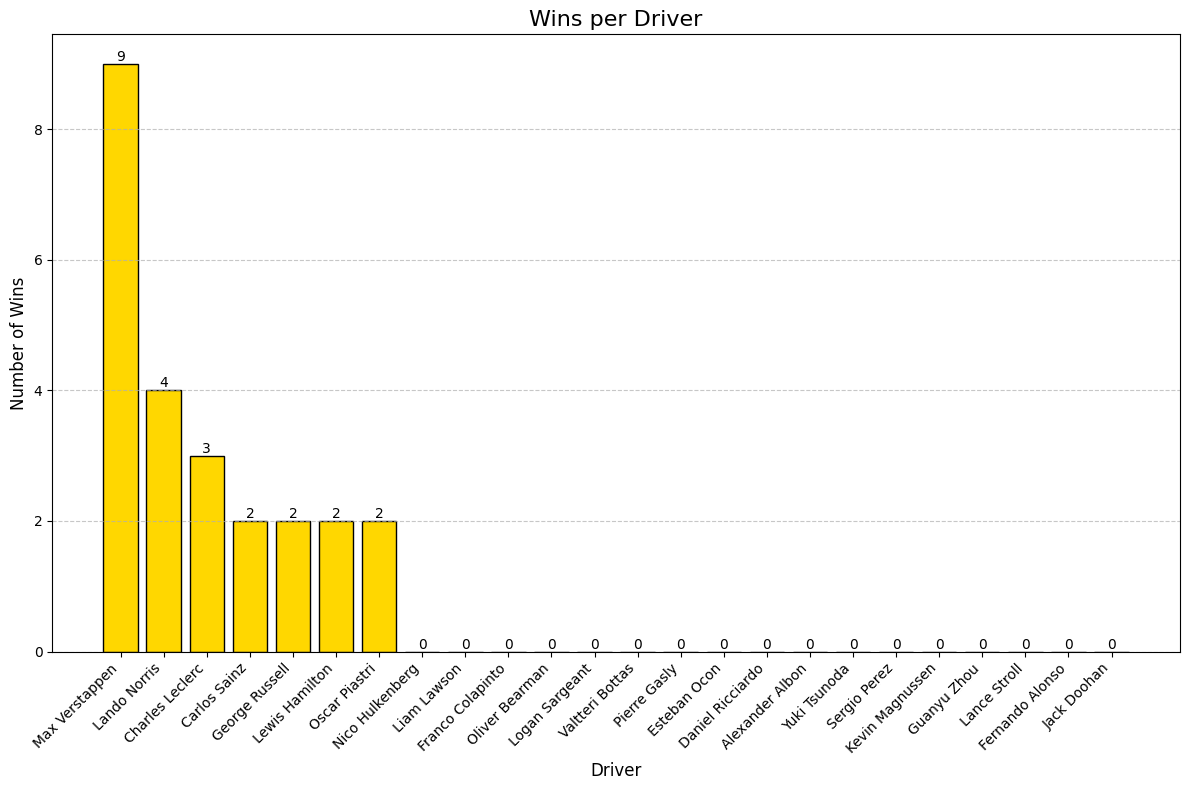

In [160]:
import pandas as pd
import matplotlib.pyplot as plt

all_drivers = df['Driver'].unique()

wins = df[df['Position'] == '1']
win_counts = wins['Driver'].value_counts()

full_win_counts = pd.Series(0, index=all_drivers)
full_win_counts.update(win_counts)

full_win_counts = full_win_counts.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.bar(full_win_counts.index, full_win_counts.values, color='gold', edgecolor='black')

plt.title('Wins per Driver', fontsize=16)
plt.xlabel('Driver', fontsize=12)
plt.ylabel('Number of Wins', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

To get a more detailed perspective on how different the racers are from each other, it a good idea to look at their average fastest laps (The average of their best performance or each track), since only looking at the wins may be deceptive.

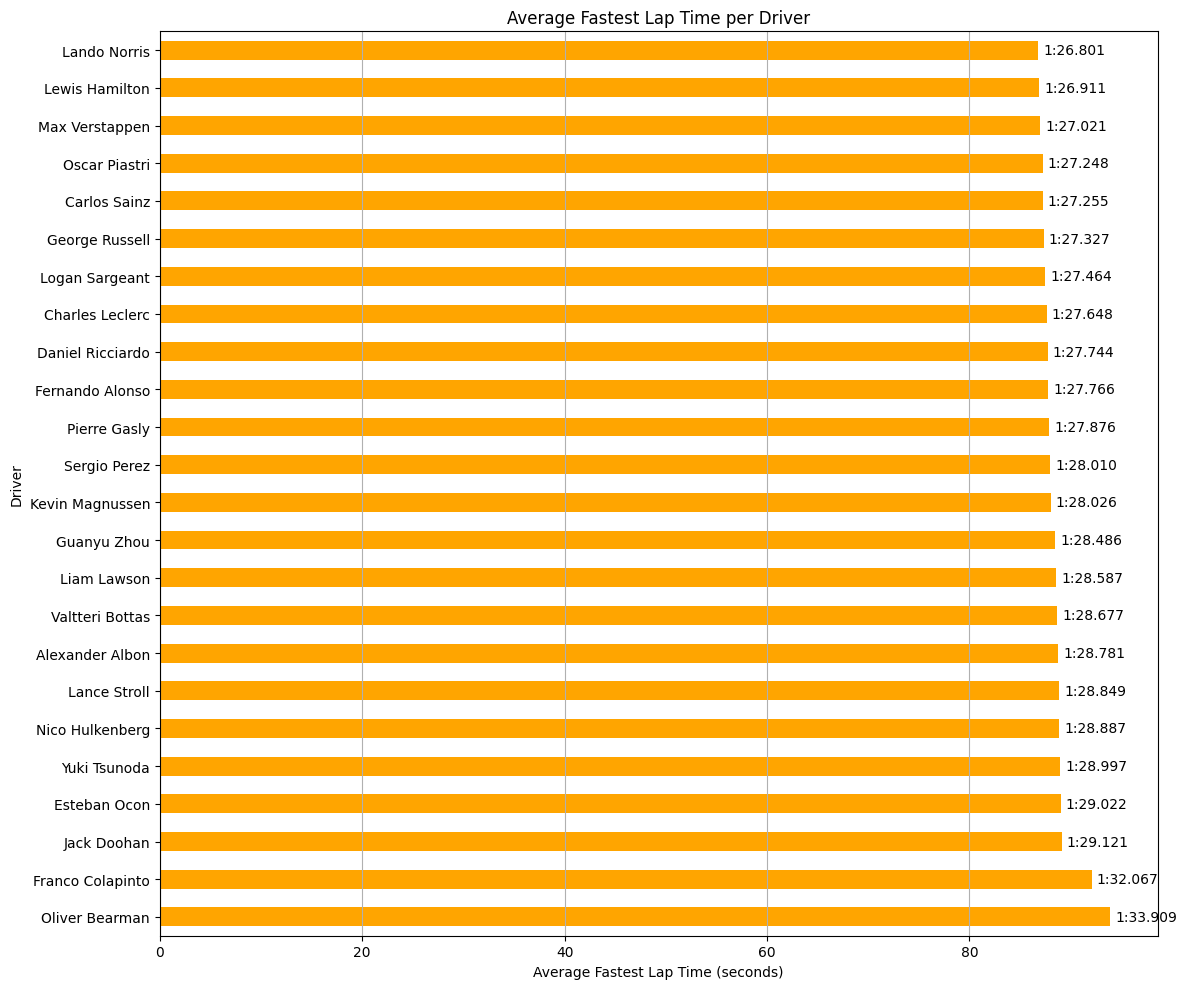

In [161]:
df_laps = df.copy()
df_laps = df_laps[df_laps['Fastest Lap Time'] != 'No time']

def lap_time_to_seconds(x):
    minutes, seconds = x.split(':')
    return int(minutes) * 60 + float(seconds)

df_laps['Fastest Lap Time (s)'] = df_laps['Fastest Lap Time'].apply(lap_time_to_seconds)
avg_fastest_lap_driver = df_laps.groupby('Driver')['Fastest Lap Time (s)'].mean().sort_values()
def seconds_to_lap_time(seconds):
    minutes = int(seconds // 60)
    secs = seconds % 60
    return f"{minutes}:{secs:06.3f}"

plt.figure(figsize=(12,10))
bars = avg_fastest_lap_driver.plot(kind='barh', color='orange')
plt.xlabel('Average Fastest Lap Time (seconds)')
plt.title('Average Fastest Lap Time per Driver')
plt.grid(axis='x')
plt.gca().invert_yaxis()

for index, value in enumerate(avg_fastest_lap_driver):
    lap_time_formatted = seconds_to_lap_time(value)
    plt.text(value + 0.5, index, lap_time_formatted, va='center')
plt.tight_layout()
plt.show()

As we can see, the difference from driver to driver often is a fragment of a second. Having that data we can also show the number of wins per Team:

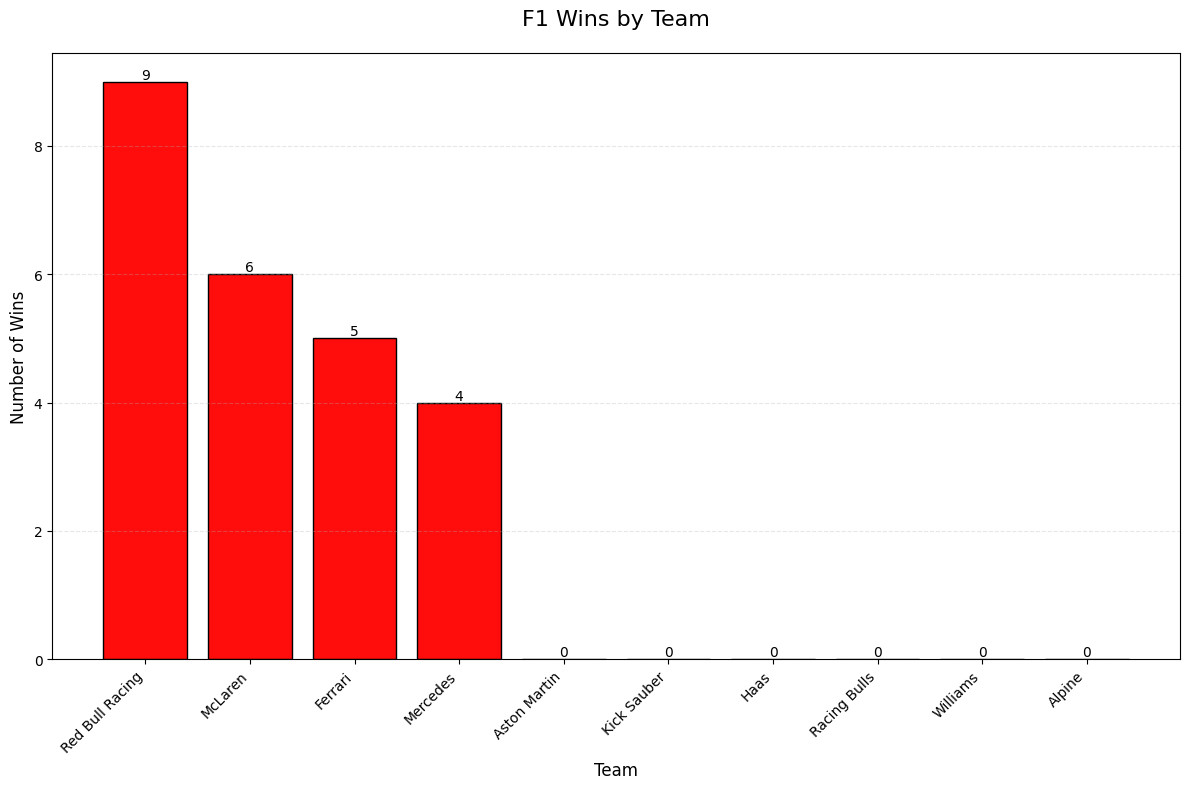

In [162]:
all_teams = df['Team'].unique()
team_wins = df[df['Position'] == '1']
team_win_counts = team_wins['Team'].value_counts()
full_team_win_counts = pd.Series(0, index=all_teams)
full_team_win_counts.update(team_win_counts)

full_team_win_counts = full_team_win_counts.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.bar(full_team_win_counts.index, full_team_win_counts.values, 
               color='#ff0d0d', edgecolor='black')

plt.title('F1 Wins by Team', fontsize=16, pad=20)
plt.xlabel('Team', fontsize=12)
plt.ylabel('Number of Wins', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Let's analyse the tracks themselves. It's interesting to see which tracks are the most problematic for the drivers. Which ones result it the most amounts of NCs?

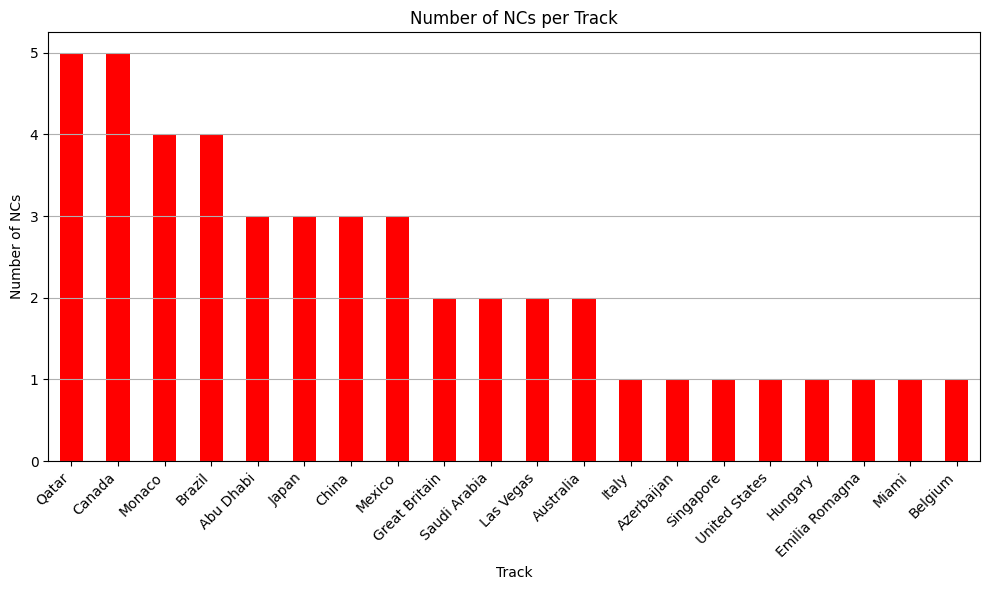

In [163]:
nc_df = df[df['Position'] == 'NC']
nc_counts = nc_df['Track'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,6))
nc_counts.plot(kind='bar', color='red')
plt.title('Number of NCs per Track')
plt.xlabel('Track')
plt.ylabel('Number of NCs')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

As we saw before, some of the racers DO finish their races, however since they get lapped, they don't complete the full number of laps needed. Let's look into who these drivers are:

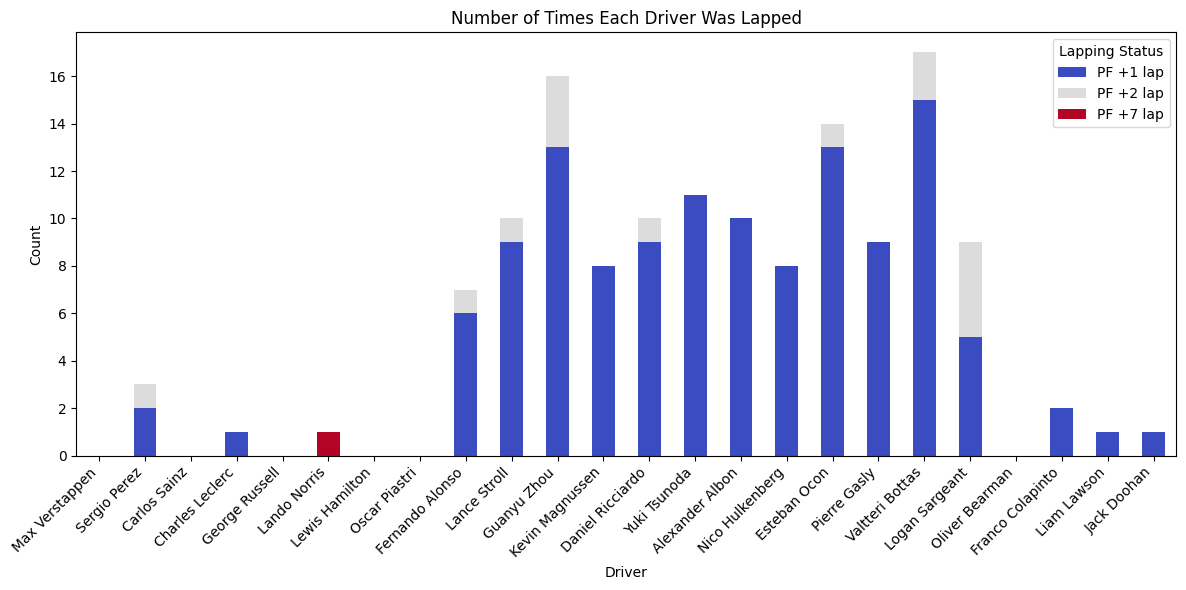

In [164]:
all_drivers = df['Driver'].unique()
pf_laps = df[df['Absolute Time'].str.contains('PF', na=False)].copy()
pf_laps['PF Status'] = pf_laps['Absolute Time'].str.extract(r'(PF \+\d+ laps?)')
pf_counts = pf_laps.groupby(['Driver', 'PF Status']).size().unstack(fill_value=0)
pf_counts = pf_counts.reindex(all_drivers, fill_value=0)
pf_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title("Number of Times Each Driver Was Lapped")
plt.ylabel("Count")
plt.xlabel("Driver")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Lapping Status")
plt.tight_layout()
plt.show()

Let's take a look at the track themselves. It's interesting to see which ones require more time. We can do that by taking the average of the fastest laps of each racer for every track:

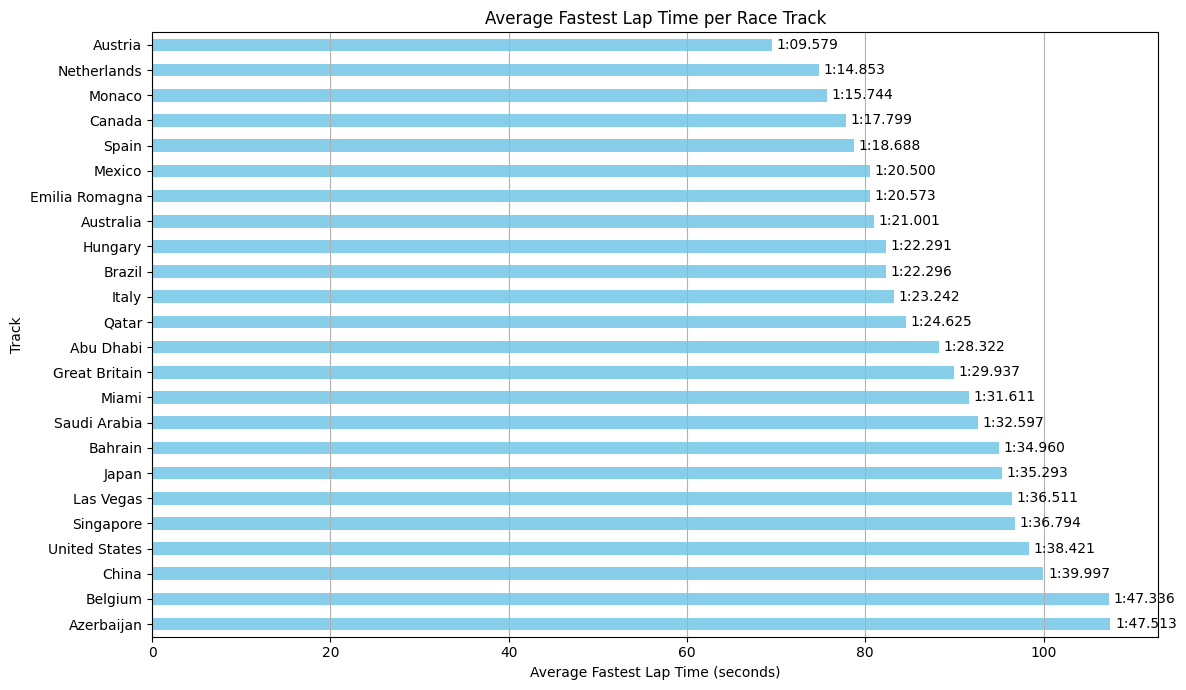

In [165]:
import pandas as pd
import matplotlib.pyplot as plt

df_laps = df.copy()
df_laps = df_laps[df_laps['Fastest Lap Time'] != 'No time']

def lap_time_to_seconds(x):
    minutes, seconds = x.split(':')
    return int(minutes) * 60 + float(seconds)

df_laps['Fastest Lap Time (s)'] = df_laps['Fastest Lap Time'].apply(lap_time_to_seconds)

avg_fastest_lap = df_laps.groupby('Track')['Fastest Lap Time (s)'].mean().sort_values()

def seconds_to_lap_time(seconds):
    minutes = int(seconds // 60)
    secs = seconds % 60
    return f"{minutes}:{secs:06.3f}"

plt.figure(figsize=(12,7))
bars = avg_fastest_lap.plot(kind='barh', color='skyblue')
plt.xlabel('Average Fastest Lap Time (seconds)')
plt.title('Average Fastest Lap Time per Race Track')
plt.grid(axis='x')

plt.gca().invert_yaxis()

for index, value in enumerate(avg_fastest_lap):
    lap_time_formatted = seconds_to_lap_time(value)
    plt.text(value + 0.5, index, lap_time_formatted, va='center')

plt.tight_layout()
plt.show()


Now that we have taken a closer look at the tracks, lets see how each driver performs on each track:

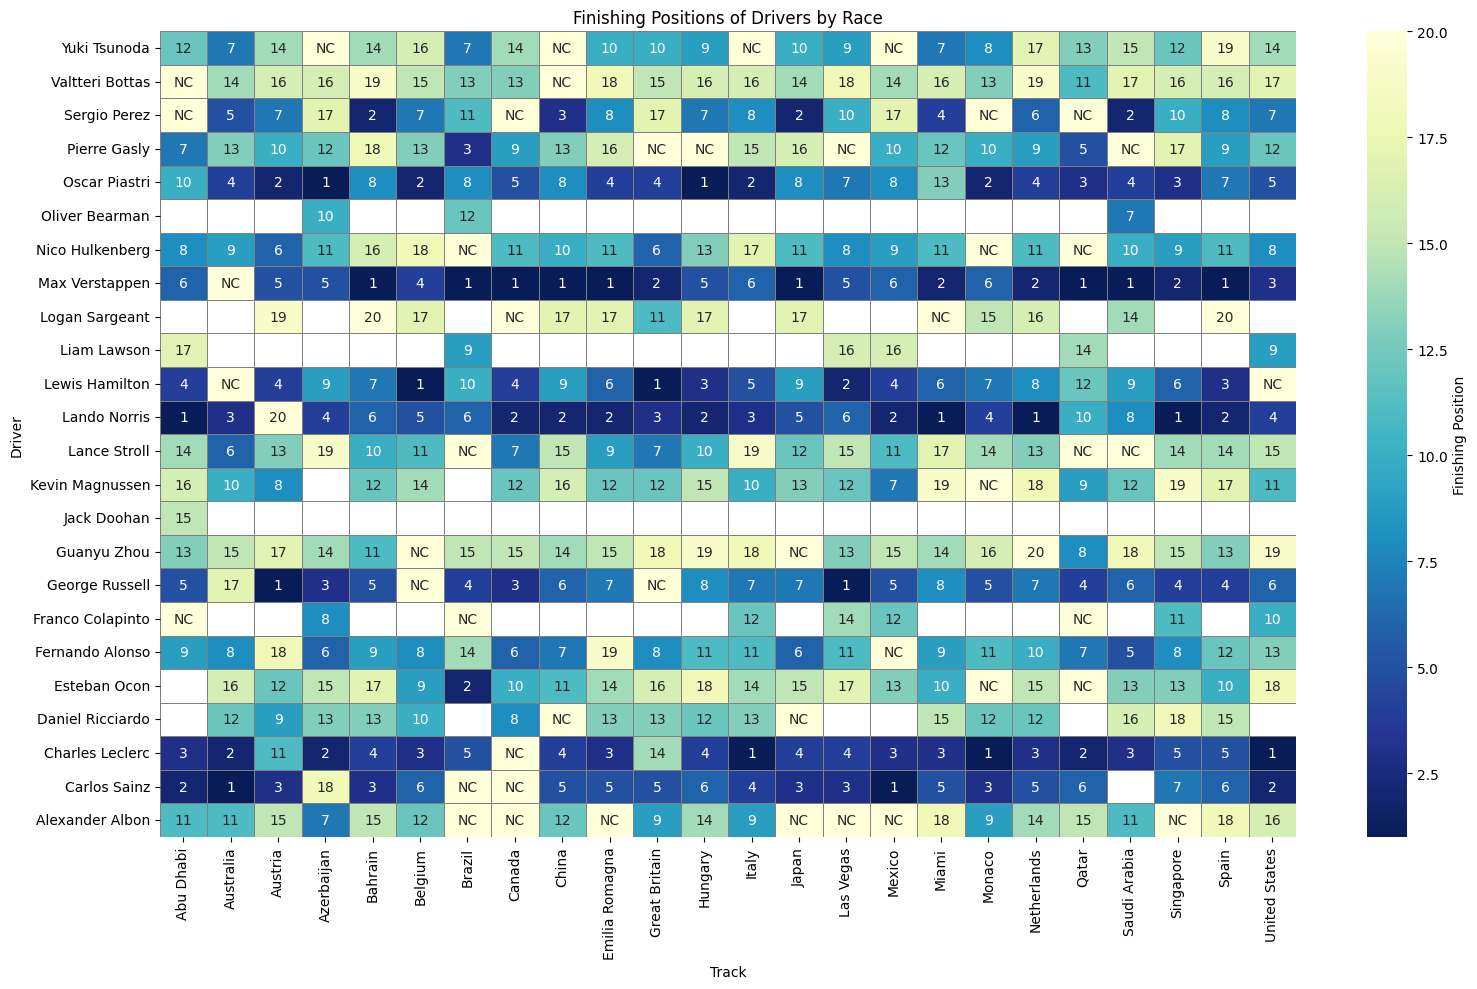

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df_race = df.copy()

df_race['Position'] = pd.to_numeric(df_race['Position'], errors='coerce')

NC_VALUE = 25
df_race['Position_Filled'] = df_race['Position'].fillna(NC_VALUE)

heatmap_data = df_race.pivot_table(index='Driver', columns='Track', values='Position_Filled')
annot_data = heatmap_data.applymap(
    lambda x: "NC" if x == NC_VALUE else (f"{int(x)}" if not pd.isna(x) else "")
)

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    annot=annot_data,
    fmt="",
    cmap='YlGnBu_r',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Finishing Position'},
    vmin=1,
    vmax=20
)

plt.title('Finishing Positions of Drivers by Race')
plt.xlabel('Track')
plt.ylabel('Driver')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Something important to look into is how positions change and what's the trend behind it.

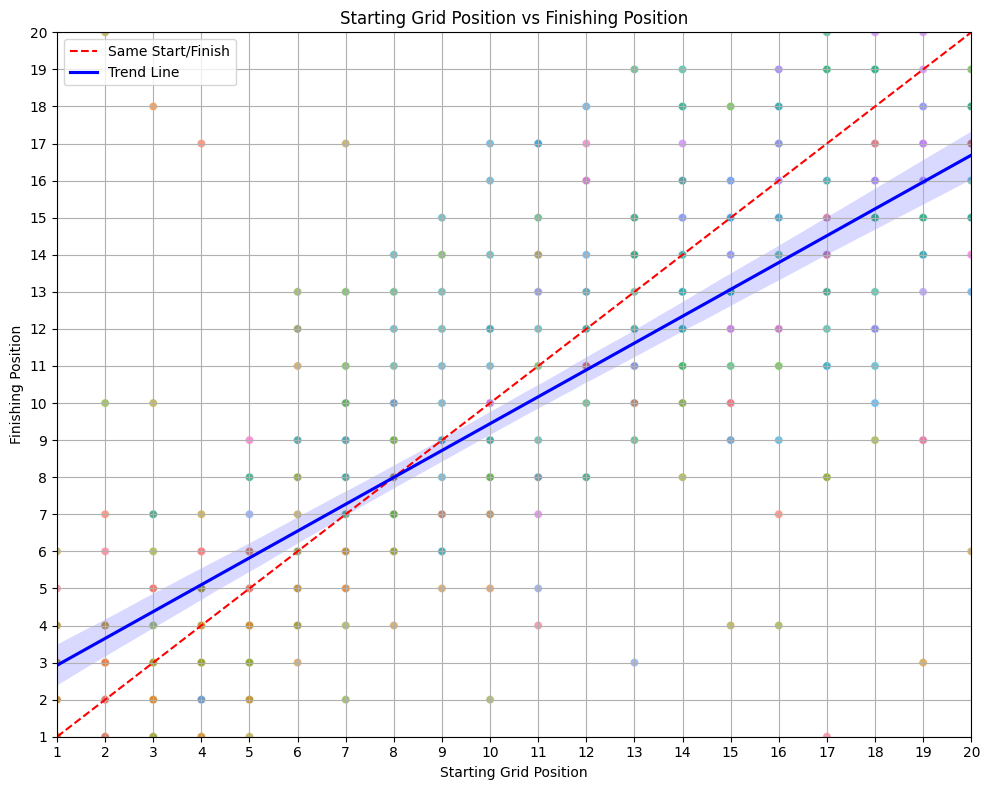

In [167]:
import seaborn as sns

df_grid = df.copy()

df_grid['Grid'] = pd.to_numeric(df_grid['Starting Grid'], errors='coerce')
df_grid['Position'] = pd.to_numeric(df_grid['Position'], errors='coerce')

df_grid = df_grid.dropna(subset=['Grid', 'Position'])

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_grid, x='Grid', y='Position', hue='Driver', alpha=0.7, legend=False)

# Diagonal reference line (Grid == Position)
plt.plot([1, 20], [1, 20], 'r--', label='Same Start/Finish')

# Regression line
sns.regplot(data=df_grid, x='Grid', y='Position', scatter=False, color='blue', label='Trend Line')

plt.xlim(1, 20)
plt.ylim(1, 20)
plt.xticks(range(1, 21))
plt.yticks(range(1, 21))

plt.xlabel('Starting Grid Position')
plt.ylabel('Finishing Position')
plt.title('Starting Grid Position vs Finishing Position')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The red dotted line represents all the results of racer who started and edned the race in the same position. The blue line represents the general trend in the dataset in the  realationship between the starting grid and the finishing positions. We can see that the two of them cross at the 8x8 dot. We can draw the conclusion that racers starting at positions from 1-7 tend to finish lower in the rankings and the racers from 9-20 normally have a better chance at upgrading their positions.

# Processing

Before we move on to select the features for the model, we need to do some more processing. For my "Absolute Time" and "Fastest Lap Time" I will be working in seconds.

In [168]:
def convert_lap_time_to_seconds(lap_time_str):
    if isinstance(lap_time_str, str) and ':' in lap_time_str:
        minutes, seconds = lap_time_str.split(':')
        return int(minutes) * 60 + float(seconds)
    return None

df['Fastest Lap Time (s)'] = df['Fastest Lap Time'].apply(convert_lap_time_to_seconds)

def convert_absolute_time_to_seconds(time_str):
    if isinstance(time_str, str) and ':' in time_str:
        try:
            h, m, s = time_str.split(':')
            return int(h) * 3600 + int(m) * 60 + float(s)
        except:
            return None
    return None

# df['Absolute Time (s)'] = df['Absolute Time'].apply(convert_absolute_time_to_seconds)



# numeric_cols = ['Starting Grid', 'Laps', 'Fastest Lap Time (s)', 'Absolute Time (s)', 'Set Fastest Lap (binary)', 'Position']
numeric_cols = ['Starting Grid', 'Laps', 'Fastest Lap Time (s)', 'Set Fastest Lap (binary)', 'Position']

df['Set Fastest Lap (binary)'] = df['Set Fastest Lap'].map({'Yes': 1, 'No': 0})


for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_cleaned = df[numeric_cols].dropna()
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Selection

Here are the features that I will be using in my model: Starting Grid, Laps, Fastest Time and Absoulte Time (both in seconds) and Set Fastest Lap (binary). The ones that I am not using are: No, Driver, Team, Time/Retired, Points. What number the driver is doesn't affect their performance, just like their own name or the one of their team. I am already using the "Absolute Time", so there is no need for "Time Retired" and the points are a result of the race, after the fact, not something that could be used for a prediction. Let's look into how the selected features work with one another. I have used a heatmap and a scatter matrix.

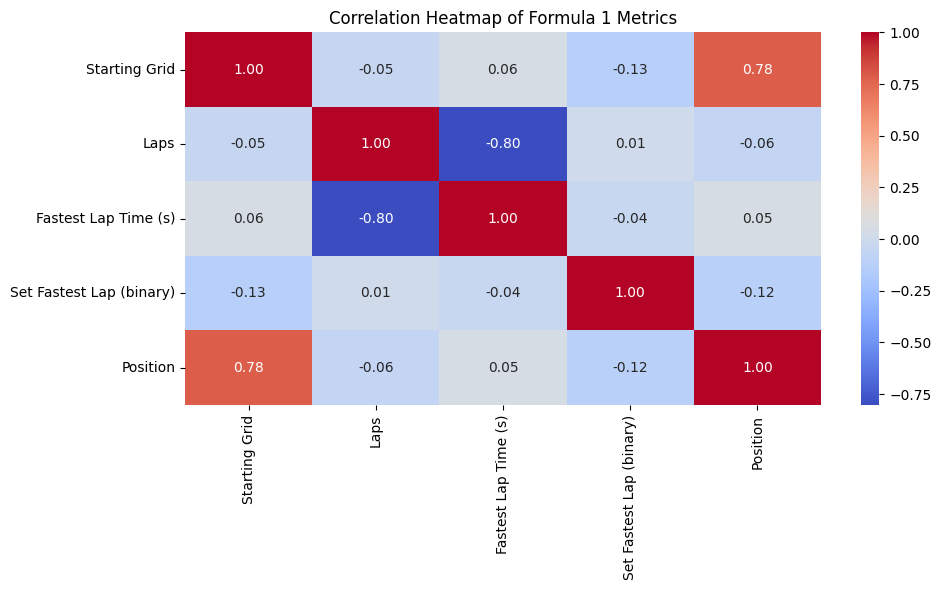

In [169]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Formula 1 Metrics")
plt.tight_layout()
plt.show()

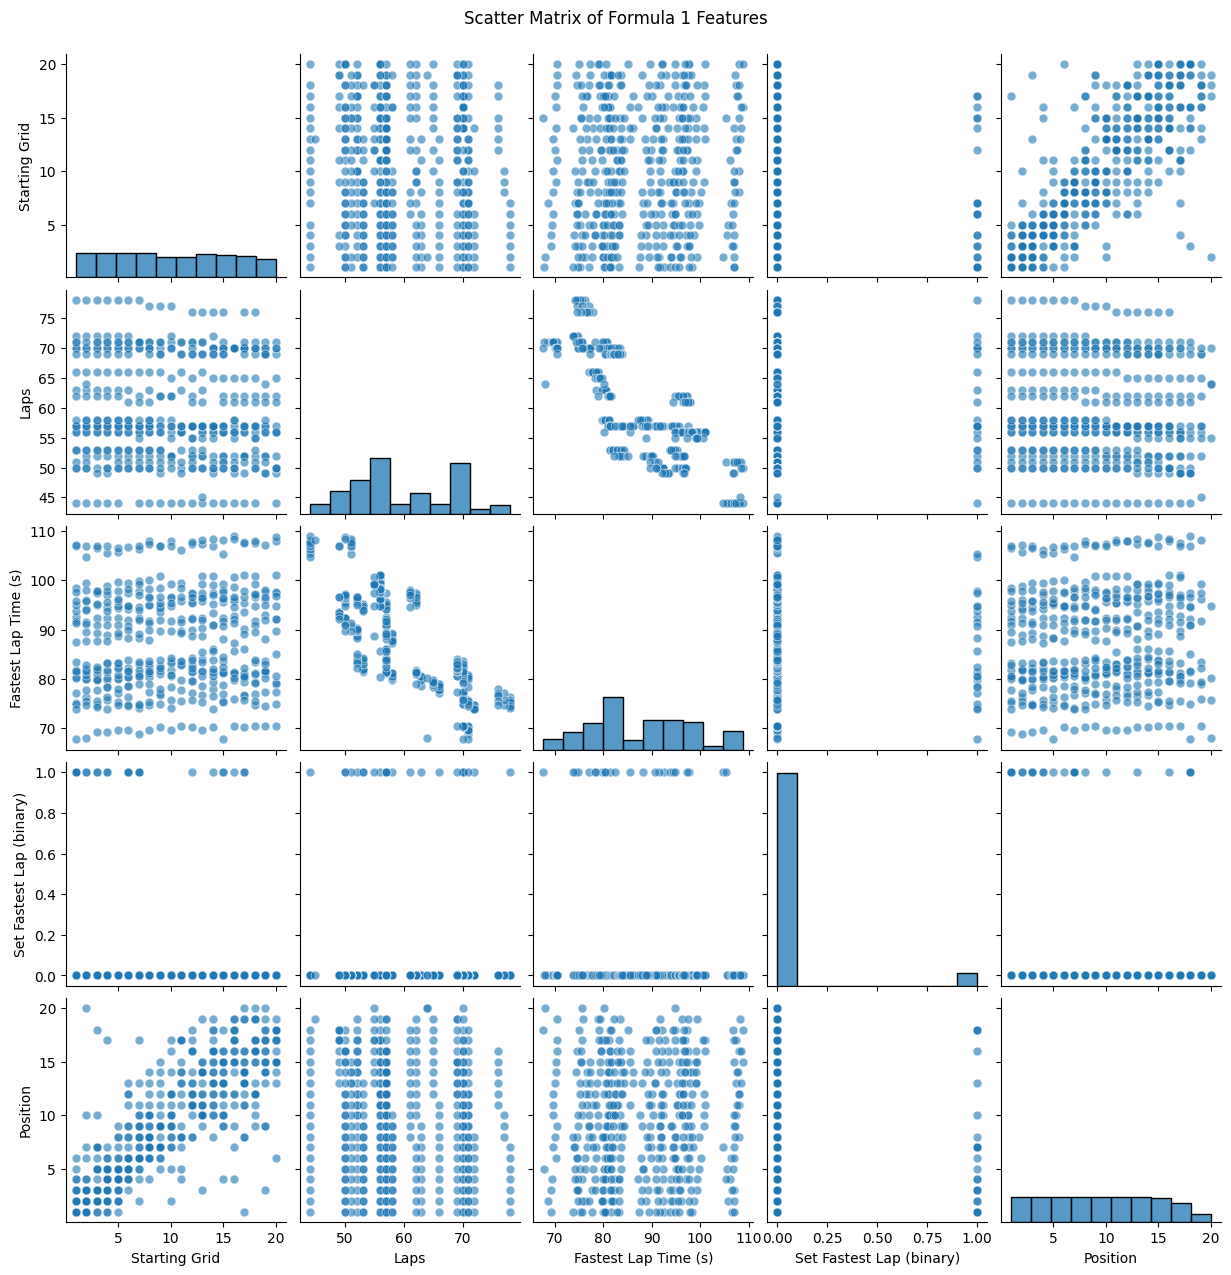

In [170]:
sns.pairplot(df_cleaned, corner=False, plot_kws={'alpha': 0.6, 's': 40})
plt.suptitle("Scatter Matrix of Formula 1 Features", y=1.02)
plt.show()

# Splitting into Train/Test

In [171]:
from sklearn.model_selection import train_test_split

X = df_cleaned[['Starting Grid', 'Laps', 'Fastest Lap Time (s)', 'Set Fastest Lap (binary)']]
y = df_cleaned['Position']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 431 observations, of which 344 are now in the train set, and 87 in the test set.


# Modeling

For this model I will be using K-Nearest Neighbours

In [172]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_clean = y_train.copy()
y_test_clean = y_test.copy()

knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train_scaled, y_train_clean)
y_pred_knn = knn_regressor.predict(X_test_scaled)
mae_knn = mean_absolute_error(y_test_clean, y_pred_knn)
mse_knn = mean_squared_error(y_test_clean, y_pred_knn)
r2_knn = r2_score(y_test_clean, y_pred_knn)
print(f"KNN Mean Absolute Error (MAE): {mae_knn}")
print(f"KNN Mean Squared Error (MSE): {mse_knn}")
print(f"KNN R-squared (R²): {r2_knn}")

KNN Mean Absolute Error (MAE): 3.2896551724137924
KNN Mean Squared Error (MSE): 20.878620689655172
KNN R-squared (R²): 0.30693945214851437


For future iterations, I will look into different types of models and compare them, to see if there aren't any better options for the predictions.

# Datasets for individual races

For optimal detail in my prediction results, I will be using the qualifying for each race to make the predictions for said race. The information for the qualifications is publicly available at the official Formula 1 site, where I will be scraping the data from to make my csv's. Let's take a look at the data:

In [173]:
qualifying_australia_df = pd.read_csv("AUSTRALIAN GRAND PRIX 2025 - QUALIFYING.csv")
qualifying_australia_df.head(20)

Pos  No             Driver                           Car        Q1  \
0    1   4       Lando Norris              McLaren Mercedes  1:15.912   
1    2  81      Oscar Piastri              McLaren Mercedes  1:16.062   
2    3   1     Max Verstappen    Red Bull Racing Honda RBPT  1:16.018   
3    4  63     George Russell                      Mercedes  1:15.971   
4    5  22       Yuki Tsunoda       Racing Bulls Honda RBPT  1:16.225   
5    6  23    Alexander Albon             Williams Mercedes  1:16.245   
6    7  16    Charles Leclerc                       Ferrari  1:16.029   
7    8  44     Lewis Hamilton                       Ferrari  1:16.213   
8    9  10       Pierre Gasly                Alpine Renault  1:16.328   
9   10  55       Carlos Sainz             Williams Mercedes  1:16.360   
10  11   6       Isack Hadjar       Racing Bulls Honda RBPT  1:16.354   
11  12  14    Fernando Alonso  Aston Martin Aramco Mercedes  1:16.288   
12  13  18       Lance Stroll  Aston Martin Aramco Mercedes  1:16.369   
13  14   7        Jack Doohan                Alpine Renault  1:16.315   
14  15   5  Gabriel Bortoleto           Kick Sauber Ferrari  1:16.516   
15  16  12     Kimi Antonelli                      Mercedes  1:16.525   
16  17  27    Nico Hulkenberg           Kick Sauber Ferrari  1:16.579   
17  18  30        Liam Lawson    Red Bull Racing Honda RBPT  1:17.094   
18  19  31       Esteban Ocon                  Haas Ferrari  1:17.147   
19  NC  87     Oliver Bearman                  Haas Ferrari       DNS   

          Q2        Q3  Laps             Team  
0   1:15.415  1:15.096    20          McLaren  
1   1:15.468  1:15.180    18          McLaren  
2   1:15.565  1:15.481    17  Red Bull Racing  
3   1:15.798  1:15.546    21         Mercedes  
4   1:16.009  1:15.670    18     Racing Bulls  
5   1:16.017  1:15.737    21         Williams  
6   1:15.827  1:15.755    20          Ferrari  
7   1:15.919  1:15.973    23          Ferrari  
8   1:16.112  1:15.980    21           Alpine  
9   1:15.931  1:16.062    21         Williams  
10  1:16.175       NaN    12     Racing Bulls  
11  1:16.453       NaN    13     Aston Martin  
12  1:16.483       NaN    15     Aston Martin  
13  1:16.863       NaN    15           Alpine  
14  1:17.520       NaN    13      Kick Sauber  
15       NaN       NaN     9         Mercedes  
16       NaN       NaN     9      Kick Sauber  
17       NaN       NaN     7     Racing Bulls  
18       NaN       NaN     9             Haas  
19       NaN       NaN     1             Haas

Source: https://www.formula1.com/en/results/2025/races/1254/australia/qualifying

Something we can notice is that not all drivers have a time registered for Q2 or Q3 and the number of laps is uneven. Let me explain the reason behind this: The qualicifation process is divided in three rounds: Q1, Q2 and Q3. In Q1 all the racers take part, however not all of them get to participate in the next round - the slowest 5 are being eliminated. This process is repeated in Q2 going into Q3, the slowest 5 are eliminated. Q1 takes 18 minutes and has all 20 drivers, Q2 takes 15 minutes and has 15 drivers and lastly Q3 lasts 12 minutes and has the fastest 10 drivers. The drivers are being judged on the fastest time they can produce, which is being recorded for them in the respective qualifying period.

The model we created above and trained uses the following features: 'Starting Grid', 'Laps', 'Fastest Lap Time (s)', 'Set Fastest Lap (binary). We can get the starting grid from the quali. results. The amount of laps each race has until it's finished is publicly available information, so we can "hard code" it per race. The Fastest Lap Time and whether or not a racer has set the fastest lap is also information we can get from the qualification results. The main idea now is to use the same features and give them to the model so that we can do the predictions. Before that though, we should do a bit of processing.

In [174]:
def time_to_seconds(time_str):
    try:
        minutes, rest = time_str.split(':')
        seconds = float(rest)
        return int(minutes) * 60 + seconds
    except:
        return "No Time"


for session in ['Q1', 'Q2', 'Q3']:
    qualifying_australia_df[session] = qualifying_australia_df[session].fillna("No Time")
    qualifying_australia_df[session] = qualifying_australia_df[session].apply(time_to_seconds)

qualifying_australia_df.head(20)

Pos  No             Driver                           Car       Q1       Q2  \
0    1   4       Lando Norris              McLaren Mercedes   75.912   75.415   
1    2  81      Oscar Piastri              McLaren Mercedes   76.062   75.468   
2    3   1     Max Verstappen    Red Bull Racing Honda RBPT   76.018   75.565   
3    4  63     George Russell                      Mercedes   75.971   75.798   
4    5  22       Yuki Tsunoda       Racing Bulls Honda RBPT   76.225   76.009   
5    6  23    Alexander Albon             Williams Mercedes   76.245   76.017   
6    7  16    Charles Leclerc                       Ferrari   76.029   75.827   
7    8  44     Lewis Hamilton                       Ferrari   76.213   75.919   
8    9  10       Pierre Gasly                Alpine Renault   76.328   76.112   
9   10  55       Carlos Sainz             Williams Mercedes    76.36   75.931   
10  11   6       Isack Hadjar       Racing Bulls Honda RBPT   76.354   76.175   
11  12  14    Fernando Alonso  Aston Martin Aramco Mercedes   76.288   76.453   
12  13  18       Lance Stroll  Aston Martin Aramco Mercedes   76.369   76.483   
13  14   7        Jack Doohan                Alpine Renault   76.315   76.863   
14  15   5  Gabriel Bortoleto           Kick Sauber Ferrari   76.516    77.52   
15  16  12     Kimi Antonelli                      Mercedes   76.525  No Time   
16  17  27    Nico Hulkenberg           Kick Sauber Ferrari   76.579  No Time   
17  18  30        Liam Lawson    Red Bull Racing Honda RBPT   77.094  No Time   
18  19  31       Esteban Ocon                  Haas Ferrari   77.147  No Time   
19  NC  87     Oliver Bearman                  Haas Ferrari  No Time  No Time   

         Q3  Laps             Team  
0    75.096    20          McLaren  
1     75.18    18          McLaren  
2    75.481    17  Red Bull Racing  
3    75.546    21         Mercedes  
4     75.67    18     Racing Bulls  
5    75.737    21         Williams  
6    75.755    20          Ferrari  
7    75.973    23          Ferrari  
8     75.98    21           Alpine  
9    76.062    21         Williams  
10  No Time    12     Racing Bulls  
11  No Time    13     Aston Martin  
12  No Time    15     Aston Martin  
13  No Time    15           Alpine  
14  No Time    13      Kick Sauber  
15  No Time     9         Mercedes  
16  No Time     9      Kick Sauber  
17  No Time     7     Racing Bulls  
18  No Time     9             Haas  
19  No Time     1             Haas

# Prediction for the Next Race (Australian Grand Prix, Race No 1)

In [180]:
qualifying_australia_df['Starting Grid'] = pd.to_numeric(qualifying_australia_df['Pos'], errors='coerce')
qualifying_australia_df[['Q1', 'Q2', 'Q3']] = qualifying_australia_df[['Q1', 'Q2', 'Q3']].replace('No Time', np.nan).astype(float)
qualifying_australia_df['Fastest Lap Time (s)'] = qualifying_australia_df[['Q1', 'Q2', 'Q3']].min(axis=1)
qualifying_australia_df['Laps'] = 58
qualifying_australia_df['Set Fastest Lap (binary)'] = 0

# Assign fastest lap
fastest_driver_idx = qualifying_australia_df['Fastest Lap Time (s)'].idxmin()
qualifying_australia_df.loc[fastest_driver_idx, 'Set Fastest Lap (binary)'] = 1

features = ['Starting Grid', 'Laps', 'Fastest Lap Time (s)', 'Set Fastest Lap (binary)']
predictable_df = qualifying_australia_df.dropna(subset=features).copy()
unpredictable_df = qualifying_australia_df[~qualifying_australia_df.index.isin(predictable_df.index)].copy()

# Predict positions with KNN
X_qual = predictable_df[features]
X_qual_scaled = scaler.transform(X_qual)
predicted_positions = knn_regressor.predict(X_qual_scaled)
predictable_df['Predicted Position'] = predicted_positions
predictable_df['Predicted Position'] = predictable_df['Predicted Position'].rank(method='first').astype(int)

if not unpredictable_df.empty:
    start_rank = predictable_df['Predicted Position'].max() + 1
    unpredictable_df['Predicted Position'] = range(start_rank, start_rank + len(unpredictable_df))

final_df = pd.concat([predictable_df, unpredictable_df], ignore_index=True)
final_df = final_df.sort_values(by='Predicted Position').reset_index(drop=True)
final_df.to_csv('predicted_results_australia.csv', index=False)


print(final_df[['Driver', 'Team', 'Starting Grid', 'Predicted Position']])

               Driver             Team  Starting Grid  Predicted Position
0       Oscar Piastri          McLaren            2.0                   1
1      Max Verstappen  Red Bull Racing            3.0                   2
2        Lando Norris          McLaren            1.0                   3
3        Yuki Tsunoda     Racing Bulls            5.0                   4
4      George Russell         Mercedes            4.0                   5
5     Alexander Albon         Williams            6.0                   6
6     Charles Leclerc          Ferrari            7.0                   7
7        Carlos Sainz         Williams           10.0                   8
8      Lewis Hamilton          Ferrari            8.0                   9
9        Pierre Gasly           Alpine            9.0                  10
10       Isack Hadjar     Racing Bulls           11.0                  11
11    Fernando Alonso     Aston Martin           12.0                  12
12       Lance Stroll     Aston Martin

# Team Results

In Formula 1, points are awarded based on finishing positions in the race, with different point values assigned to the top 10 finishers. Finishers outside of the top 10 aren't awared any points. The current F1 points distribution is as follows:

1st place: 25 points

2nd place: 18 points

3rd place: 15 points

4th place: 12 points

5th place: 10 points

6th place: 8 points

7th place: 6 points

8th place: 4 points

9th place: 2 points

10th place: 1 point

In [183]:
predicted_results_df = pd.read_csv('predicted_results_australia.csv')
# Points allocation based on F1 finishing positions
points_dict = {
    1: 25, 2: 18, 3: 15, 4: 12, 5: 10,
    6: 8, 7: 6, 8: 4, 9: 2, 10: 1
}

def get_points(position):
    # If position is greater than 10, no points are awarded
    return points_dict.get(position, 0)


predicted_results_df['Predicted Points'] = predicted_results_df['Predicted Position'].apply(get_points)
team_points = predicted_results_df.groupby('Team')['Predicted Points'].sum().reset_index()
team_points = team_points.sort_values(by='Predicted Points', ascending=False)
team_points['Team Rank'] = team_points['Predicted Points'].rank(method='first', ascending=False).astype(int)
team_points = team_points.sort_values(by='Team Rank')
print(team_points[['Team', 'Predicted Points', 'Team Rank']])

              Team  Predicted Points  Team Rank
5          McLaren                40          1
8  Red Bull Racing                18          2
7     Racing Bulls                12          3
9         Williams                12          4
6         Mercedes                10          5
2          Ferrari                 8          6
0           Alpine                 1          7
1     Aston Martin                 0          8
3             Haas                 0          9
4      Kick Sauber                 0         10
